runs the same code as heat_1d_1d_example.ipynb but now with the new heat_nn implementation

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from heat_612 import heat_nn
np.random.seed(238)
torch.manual_seed(301)

/tmp/ipykernel_77651/3466224877.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_colloc = torch.tensor(xs, dtype=torch.float32).view(-1,1)
/tmp/ipykernel_77651/3466224877.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_colloc = torch.tensor(ts, dtype=torch.float32).view(-1,1)


Epoch 0, Loss: 89.809654, MSE: 0.204339
Epoch 50, Loss: 72.093391, MSE: 0.207498
Epoch 100, Loss: 67.990234, MSE: 0.191626
Epoch 150, Loss: 65.586662, MSE: 0.184552
Epoch 200, Loss: 63.919636, MSE: 0.178301
Epoch 250, Loss: 61.921181, MSE: 0.170960
Epoch 300, Loss: 60.230637, MSE: 0.164757
Epoch 350, Loss: 58.655514, MSE: 0.159432
Epoch 400, Loss: 57.366669, MSE: 0.154655
Epoch 450, Loss: 56.168549, MSE: 0.149912
Epoch 500, Loss: 54.977562, MSE: 0.145289
Epoch 550, Loss: 57.252308, MSE: 0.146465
Epoch 600, Loss: 49.164711, MSE: 0.123605
Epoch 650, Loss: 44.038673, MSE: 0.083577
Epoch 700, Loss: 28.640572, MSE: 0.049039
Epoch 749, Loss: 9.112324, MSE: 0.012833
Epoch 0, Loss: 1.643445, MSE: 0.000540
Epoch 1, Loss: 0.281906, MSE: 0.000021
Epoch 2, Loss: 0.015762, MSE: 0.000002
Epoch 3, Loss: 0.003614, MSE: 0.000000
Epoch 4, Loss: 0.001505, MSE: 0.000000
Epoch 5, Loss: 0.000793, MSE: 0.000000
Epoch 6, Loss: 0.000438, MSE: 0.000000
Epoch 7, Loss: 0.000291, MSE: 0.000000
Epoch 8, Loss: 0.000

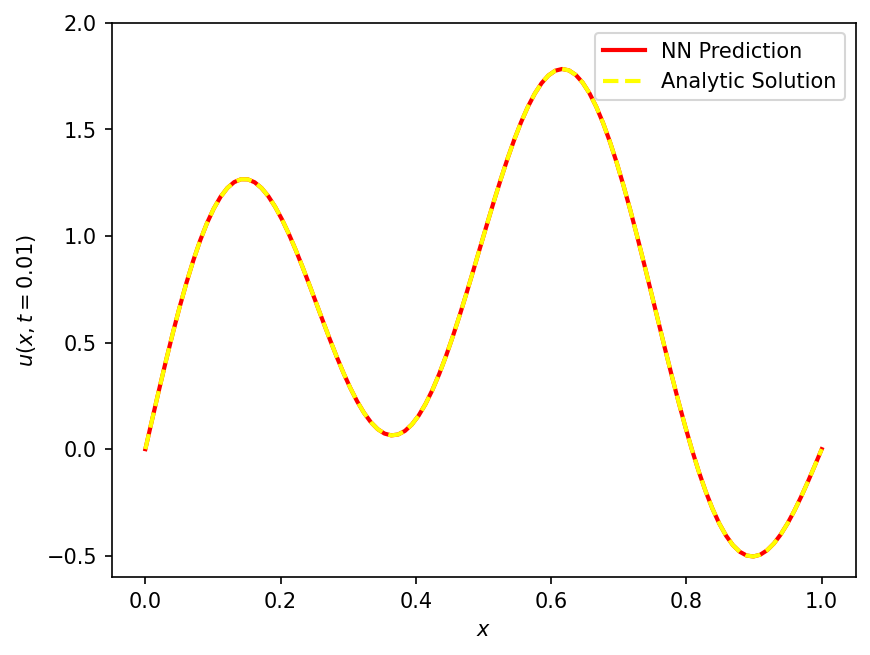

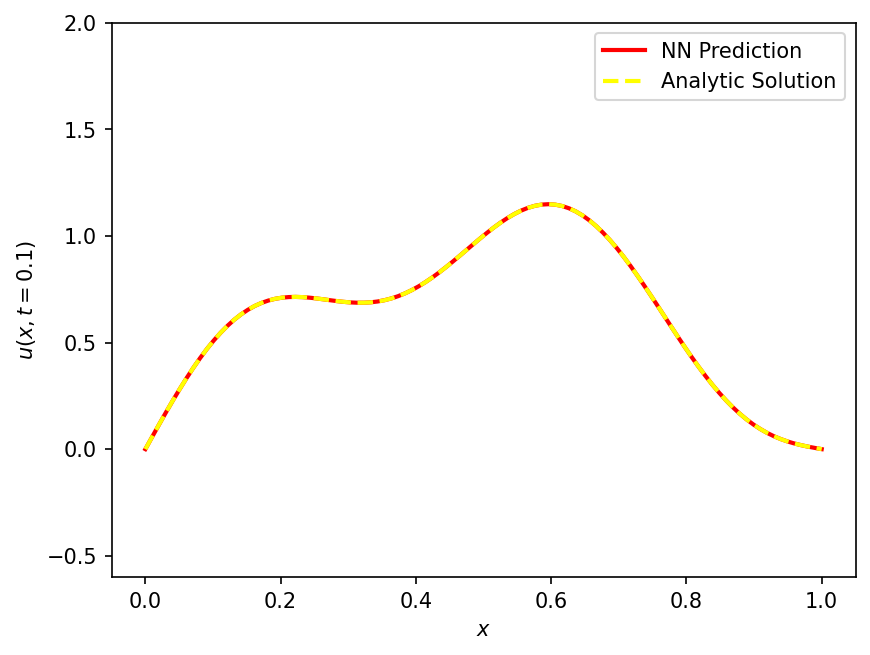

L^2 error:         9.491514e-05
L_^{infty}_error:  0.0002940297


In [4]:
#code for notizen time scale vs no time scale
np.random.seed(238)
torch.manual_seed(301)
layers = [32, 64, 128, 128, 1]
#in this example: the output layer uses identity as activation func and all the hidden layers use tanh
activations = [torch.tanh]*(len(layers)-1) + [None]
dim=1
kappa = 0.1
u_0 = lambda x: torch.sin(torch.pi * x) + torch.sin(4 * torch.pi * x)
rhs = lambda x, t: torch.sin(torch.pi * x)
u_analytic = lambda x, t: (1 - 1 / (0.1 * torch.pi**2)) * torch.sin(torch.pi * x) * torch.exp(-torch.pi**2 * 0.1 * t
                    ) + torch.sin(4 * torch.pi * x) * torch.exp(- 16 * torch.pi**2 * 0.1 * t
                    ) + 1 / (0.1 * torch.pi**2) * torch.sin(torch.pi * x)

pde_nn = heat_nn(layers, activations, dim, u_0, kappa, rhs, reg = 0)
pde_nn.set_analytic_solution(u_analytic)
N_colloc = 100

x = np.linspace(0, 1, N_colloc)
t = np.linspace(0, 0.2, N_colloc)

xs, ts = np.meshgrid(x, t)

xs = torch.tensor(xs, dtype=torch.float32).view(-1, 1)
ts = torch.tensor(ts, dtype=torch.float32).view(-1, 1)

x_colloc = torch.tensor(xs, dtype=torch.float32).view(-1,1)
t_colloc = torch.tensor(ts, dtype=torch.float32).view(-1,1)

pde_nn.x = [x_colloc]
pde_nn.t = t_colloc

# gives relatively good results (compared to other parameters, still bad though)
pde_nn.train(lr=1e-2, weight_decay=0.0, epochs = 750, opt_time_scale =True, print_epochs=50)
# LBFGS needs approximately 100 epochs, 30 iterations for kappa = 1
# if kappa = 0.1, better choose more iterations, less epochs
pde_nn.train_lbfgs(lr=1, opt_time_scale = True, epochs=10, max_iter=100, damping = False)

for t in [0.01,0.1,]:
    x_test = torch.linspace(0,1,100).view(-1,1)
    t_test = torch.tensor([[t]]*100)  # t=0.5
    u_pred = pde_nn.trial_solution(x_test, t_test).detach().numpy()

    #compare results with analytic solution

    x_np = x_test.numpy().flatten()  # convert to 1D array for plotting
    t_val = t
    u_analytic_val = pde_nn.u_analytic(x_test, t_test)

    # Plot the results
    plt.figure(dpi=150)
    plt.plot(x_np, u_pred, color='red', label='NN Prediction', linewidth=2)
    plt.plot(x_np, u_analytic_val, '--', color='yellow', label='Analytic Solution', linewidth=2)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$u(x,t={})$'.format(t))
    plt.ylim(-0.6, 2.0)
    plt.legend()
    plt.show()

### error measured in L^2 and L^{\infty} norm
L_2_err = pde_nn.L_2_error()
L_infty_err = pde_nn.L_infty_error()
print("L^2 error:        ", L_2_err)
print("L_^{infty}_error: ", L_infty_err)

In [3]:
layers = [32, 64, 128, 128, 1]
#in this example: the output layer uses identity as activation func and all the hidden layers use tanh
activations = [torch.tanh]*(len(layers)-1) + [None]
dim=1
kappa = 0.1
u_0 = lambda x: torch.sin(torch.pi * x) + torch.sin(4 * torch.pi * x)
rhs = lambda x, t: torch.sin(torch.pi * x)
u_analytic = lambda x, t: (1 - 1 / (0.1 * torch.pi**2)) * torch.sin(torch.pi * x) * torch.exp(-torch.pi**2 * 0.1 * t
                    ) + torch.sin(4 * torch.pi * x) * torch.exp(- 16 * torch.pi**2 * 0.1 * t
                    ) + 1 / (0.1 * torch.pi**2) * torch.sin(torch.pi * x)

pde_nn = heat_nn(layers, activations, dim, u_0, kappa, rhs, reg =0)
pde_nn.set_analytic_solution(u_analytic)
N_colloc = 100

x = np.linspace(0, 1, N_colloc)
t = np.linspace(0, 0.2, N_colloc)

xs, ts = np.meshgrid(x, t)

xs = torch.tensor(xs, dtype=torch.float32).view(-1, 1)
ts = torch.tensor(ts, dtype=torch.float32).view(-1, 1)

x_colloc = torch.tensor(xs, dtype=torch.float32).view(-1,1)
t_colloc = torch.tensor(ts, dtype=torch.float32).view(-1,1)

pde_nn.x = [x_colloc]
pde_nn.t = t_colloc

t_test = 0.2 * torch.rand(1000).view(-1,1)
x_test = torch.rand(1000).view(-1,1)
# gives relatively good results (compared to other parameters, still bad though)
pde_nn.train(lr=1e-2, weight_decay=0.0, epochs = 7, opt_time_scale =False, print_epochs=50)

L_2_err = pde_nn.L_2_error()
L_infty_err = pde_nn.L_infty_error()
print(L_2_err)
print(pde_nn.L_2_error(x_test, t_test))
print(pde_nn.L_infty_error(x_test, t_test))
print(L_infty_err)


/tmp/ipykernel_94726/687368426.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_colloc = torch.tensor(xs, dtype=torch.float32).view(-1,1)
/tmp/ipykernel_94726/687368426.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_colloc = torch.tensor(ts, dtype=torch.float32).view(-1,1)


Epoch 0, Loss: 89.809654, MSE: 0.204340
Epoch 6, Loss: 77.453384, MSE: 0.185830
0.4310805
0.44511804
1.111681
1.136093


In [9]:
print(pde_nn.mse())
print(pde_nn.mse(x_test, t_test))

1.1570254e-06
5.882679e-07


In [ ]:
"""
2D Heat equation
"""

layers = [32, 64, 128, 128, 1]
activations = [torch.tanh]*(len(layers)-1) + [None]

u_0 = lambda x, y: torch.sin(torch.pi * x) * torch.sin(torch.pi * y) + torch.sin(
        2 * torch.pi * x) * torch.sin(4 * torch.pi * y)

u_analytic = lambda x, y,t: torch.sin(torch.pi * x) * torch.sin(torch.pi * y) * torch.exp(
    -2 * torch.pi**2 * t) + torch.sin(2 * torch.pi * x) * torch.sin(4 * torch.pi * x
    ) * torch.exp(-20 * torch.pi**2 * t)

dim=2
kappa = 1
rhs = lambda x, y, t: 0
pde_nn = heat_nn(layers, activations, dim, u_0, kappa, rhs)
pde_nn.set_analytic_solution(u_analytic)
N_colloc = 10
pde_nn.set_data(N_colloc)

pde_nn.train(lr=1e-2, weight_decay=0.0, epochs = 7, opt_time_scale =True, print_epochs=50)
pde_nn.train_lbfgs(lr=1, opt_time_scale = True, epochs=1, max_iter=10)


x_test = torch.linspace(0,1,100).view(-1,1)
y_test = torch.linspace(0,1,100).view(-1,1)
t_test = torch.tensor([[0.001]]*100)  # t=0.001
u_pred = pde_nn.trial_solution(x_test, y_test, t_test).detach().numpy()

Epoch 6, Loss: 3514.639404, MSE: 0.142413
Epoch 0, Loss: 3502.833008, MSE: 0.144208


In [3]:
print(pde_nn.mse())
print(pde_nn.mse(x_test, y_test, t_test))
print(x_test.shape)
#pde_nn.L_2_error(x_test, t_test)


0.2065804


NameError: name 'y_test' is not defined

In [ ]:
#analyze weight decay for rhs = 0
layers = [32, 64, 128, 128, 1]
#in this example: the output layer uses identity as activation func and all the hidden layers use tanh
activations = [torch.tanh]*(len(layers)-1) + [None]
dim=1
kappa = 1
u_0 = lambda x: torch.sin(torch.pi * x)
rhs = lambda x, t: 0
u_analytic = lambda x, t: torch.sin(torch.pi * x) * torch.exp(-torch.pi**2 * t)


pde_nn = heat_nn(layers, activations, dim, u_0, kappa, rhs)
pde_nn.set_analytic_solution(u_analytic)
N_colloc = 100

x = np.linspace(0, 1, N_colloc)
t = np.linspace(0, 0.2, N_colloc)

xs, ts = np.meshgrid(x, t)

xs = torch.tensor(xs, dtype=torch.float32).view(-1, 1)
ts = torch.tensor(ts, dtype=torch.float32).view(-1, 1)

x_colloc = torch.tensor(xs, dtype=torch.float32).view(-1,1)
t_colloc = torch.tensor(ts, dtype=torch.float32).view(-1,1)

pde_nn.x = [x_colloc]
pde_nn.t = t_colloc

# gives relatively good results (compared to other parameters, still bad though)
#pde_nn.train(lr=1e-2, weight_decay=0.0, epochs = 750, opt_time_scale =False, print_epochs=50)
# LBFGS needs approximately 100 epochs, 30 iterations for kappa = 1
# if kappa = 0.1, better choose more iterations, less epochs
pde_nn.train(lr=1e-2, weight_decay=0.0, epochs = 200, opt_time_scale =True, print_epochs=50)
pde_nn.train_lbfgs(lr=1, opt_time_scale = True, epochs=500, max_iter=10)
for t in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]:
    x_test = torch.linspace(0,1,100).view(-1,1)
    t_test = torch.tensor([[t]]*100)  # t=0.5
    u_pred = pde_nn.trial_solution(x_test, t_test).detach().numpy()

    #compare results with analytic solution

    x_np = x_test.numpy().flatten()  # convert to 1D array for plotting
    t_val = t
    u_analytic_val = pde_nn.u_analytic(x_test, t_test)

    # Plot the results
    plt.figure(figsize=(8,5))
    plt.plot(x_np, u_pred, label='NN Prediction', linewidth=2)
    plt.plot(x_np, u_analytic_val, '--', label='Analytic Solution', linewidth=2)
    plt.xlabel('x')
    plt.ylabel(f'u(x,t={t})')
    plt.ylim(-0.75, 2.0)
    plt.title('Heat Equation: NN vs Analytic Solution')
    plt.legend()
    plt.grid(True)
    plt.show()

### error measured in L^2 and L^{\infty} norm
L_2_err = pde_nn.L_2_error()
L_infty_err = pde_nn.L_infty_error()
print("L^2 error:        ", L_2_err)
print("L_^{infty}_error: ", L_infty_err)

/tmp/ipykernel_23116/3922122915.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_colloc = torch.tensor(xs, dtype=torch.float32).view(-1,1)
/tmp/ipykernel_23116/3922122915.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_colloc = torch.tensor(ts, dtype=torch.float32).view(-1,1)


Epoch 0, Loss: 31.928144, MSE: 0.107366
Epoch 50, Loss: 5.754120, MSE: 0.011418
Epoch 100, Loss: 5.740961, MSE: 0.010255
Epoch 150, Loss: 5.740918, MSE: 0.010245
Epoch 199, Loss: 5.740918, MSE: 0.010238
Epoch 0, Loss: 5.740917, MSE: 0.010238
Epoch 1, Loss: 5.740917, MSE: 0.010238
Epoch 2, Loss: 5.740917, MSE: 0.010238
Epoch 3, Loss: 5.740917, MSE: 0.010238
Epoch 4, Loss: 5.740917, MSE: 0.010238
Epoch 5, Loss: 5.740917, MSE: 0.010238
Epoch 6, Loss: 5.740917, MSE: 0.010238
Epoch 7, Loss: 5.740917, MSE: 0.010238
Epoch 8, Loss: 5.740917, MSE: 0.010238
Epoch 9, Loss: 5.740917, MSE: 0.010238
Epoch 10, Loss: 5.740917, MSE: 0.010238
Epoch 11, Loss: 5.740917, MSE: 0.010238
Epoch 12, Loss: 5.740917, MSE: 0.010238
Epoch 13, Loss: 5.740917, MSE: 0.010238
Epoch 14, Loss: 5.740917, MSE: 0.010238
Epoch 15, Loss: 5.740917, MSE: 0.010238
Epoch 16, Loss: 5.740917, MSE: 0.010238
Epoch 17, Loss: 5.740917, MSE: 0.010238
Epoch 18, Loss: 5.740917, MSE: 0.010238
Epoch 19, Loss: 5.740917, MSE: 0.010238
Epoch 2

KeyboardInterrupt: 

In [6]:
#analyze weight decay for rhs = complex
weights = np.logspace(-4,1,5)
list_l2errors_train = []
list_linf_errors_train = []
list_l2errors_test = []
list_linf_errors_test = []
t_test = 0.2 * torch.rand(1000).view(-1,1)
x_test = torch.rand(1000).view(-1,1)
for w in weights:
    print(w)
    layers = [32, 64, 128, 128, 1]
    #in this example: the output layer uses identity as activation func and all the hidden layers use tanh
    activations = [torch.tanh]*(len(layers)-1) + [None]
    dim=1
    kappa = 0.1
    u_0 = lambda x: torch.sin(torch.pi * x) + torch.sin(4 * torch.pi * x)
    rhs = lambda x, t: torch.sin(torch.pi * x)
    u_analytic = lambda x, t: (1 - 1 / (0.1 * torch.pi**2)) * torch.sin(torch.pi * x) * torch.exp(-torch.pi**2 * 0.1 * t
                        ) + torch.sin(4 * torch.pi * x) * torch.exp(- 16 * torch.pi**2 * 0.1 * t
                        ) + 1 / (0.1 * torch.pi**2) * torch.sin(torch.pi * x)

    pde_nn = heat_nn(layers, activations, dim, u_0, kappa, rhs, w)
    pde_nn.set_analytic_solution(u_analytic)
    N_colloc = 100

    x = np.linspace(0, 1, N_colloc)
    t = np.linspace(0, 0.2, N_colloc)

    xs, ts = np.meshgrid(x, t)

    xs = torch.tensor(xs, dtype=torch.float32).view(-1, 1)
    ts = torch.tensor(ts, dtype=torch.float32).view(-1, 1)

    x_colloc = torch.tensor(xs, dtype=torch.float32).view(-1,1)
    t_colloc = torch.tensor(ts, dtype=torch.float32).view(-1,1)

    pde_nn.x = [x_colloc]
    pde_nn.t = t_colloc

    # gives relatively good results (compared to other parameters, still bad though)
    pde_nn.train(lr=1e-2, weight_decay=0.0, epochs = 7, opt_time_scale =False, print_epochs = 50)
    # LBFGS needs approximately 100 epochs, 30 iterations for kappa = 1
    # if kappa = 0.1, better choose more iterations, less epochs
    pde_nn.train_lbfgs(lr=1, opt_time_scale = False, epochs=1, max_iter=100, print_epochs = 1, damping = False)
    L_2_err_train = pde_nn.L_2_error()
    L_infty_err_train = pde_nn.L_infty_error()
    L_2_err_test = pde_nn.L_2_error(x_test, t_test)
    L_infty_err_test = pde_nn.L_infty_error(x_test, t_test)
    list_l2errors_train.append(L_2_err_train)
    list_linf_errors_train.append(L_infty_err_train)
    list_l2errors_test.append(L_2_err_test)
    list_linf_errors_test.append(L_infty_err_test)



0.0001


/tmp/ipykernel_77651/3793314641.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_colloc = torch.tensor(xs, dtype=torch.float32).view(-1,1)
/tmp/ipykernel_77651/3793314641.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_colloc = torch.tensor(ts, dtype=torch.float32).view(-1,1)


Epoch 0, Loss: 89.793930, MSE: 0.203620
Epoch 6, Loss: 77.005371, MSE: 0.191406
Epoch 0, Loss: nan, MSE: nan
0.0017782794100389228
Epoch 0, Loss: 89.960648, MSE: 0.203043
Epoch 6, Loss: 78.240089, MSE: 0.190848
Epoch 0, Loss: 1426222162120802304.000000, MSE: 4234667028905984.000000
0.03162277660168379
Epoch 0, Loss: 93.700867, MSE: 0.205467
Epoch 6, Loss: 88.443497, MSE: 0.199141
Epoch 0, Loss: 8834189547916679329087488.000000, MSE: 216295329281769209856.000000
0.5623413251903491
Epoch 0, Loss: 160.150818, MSE: 0.206945
Epoch 6, Loss: 106.012878, MSE: 0.206893
Epoch 0, Loss: 89.744804, MSE: 0.206277
10.0
Epoch 0, Loss: 1327.251587, MSE: 0.207170
Epoch 6, Loss: 362.134094, MSE: 0.207028
Epoch 0, Loss: 89.776253, MSE: 0.206966


In [10]:
np.random.seed(123)
torch.manual_seed(2389)
MAX_RETRIES = 3          # run at most 3 times per weight
THRESHOLD = 10        # any threshold you consider "too bad"
weights = np.concatenate(([0.0], np.logspace(-4, 1, 5)))
list_l2errors_train = []
list_linf_errors_train = []
list_l2errors_test = []
list_linf_errors_test = []
t_test = 0.2 * torch.rand(1000).view(-1,1)
x_test = torch.rand(1000).view(-1,1)

for w in weights:
    print(f"Testing weight decay: {w}")

    success = False

    for attempt in range(1, MAX_RETRIES + 1):
        print(f"  Attempt {attempt} for weight {w}")

        # === initialize model fresh ===
        layers = [32, 64, 128, 128, 1]
        activations = [torch.tanh]*(len(layers)-1) + [None]
        dim=1
        kappa = 0.1
        u_0 = lambda x: torch.sin(torch.pi * x) + torch.sin(4 * torch.pi * x)
        rhs = lambda x, t: torch.sin(torch.pi * x)
        u_analytic = lambda x, t: (1 - 1/(0.1*torch.pi**2))*torch.sin(torch.pi*x)*torch.exp(-torch.pi**2*0.1*t) \
                                  + torch.sin(4*torch.pi*x)*torch.exp(-16*torch.pi**2*0.1*t) \
                                  + 1/(0.1*torch.pi**2)*torch.sin(torch.pi*x)

        pde_nn = heat_nn(layers, activations, dim, u_0, kappa, rhs, w)
        pde_nn.set_analytic_solution(u_analytic)

        # === collocation points ===
        x = np.linspace(0, 1, 100)
        t = np.linspace(0, 0.2, 100)
        xs, ts = np.meshgrid(x, t)

        x_colloc = torch.tensor(xs, dtype=torch.float32).view(-1,1)
        t_colloc = torch.tensor(ts, dtype=torch.float32).view(-1,1)

        pde_nn.x = [x_colloc]
        pde_nn.t = t_colloc

        # === training ===
        pde_nn.train(lr=1e-2, weight_decay=0.0, epochs=750, opt_time_scale=False, print_epochs=0)
        pde_nn.train_lbfgs(lr=1, opt_time_scale=False, epochs=10, max_iter=100, print_epochs=0)

        # === evaluate ===
        err = pde_nn.L_2_error(x_test, t_test)

        if err < THRESHOLD:
            print(f"  Success! L2 error = {err:.3e}")
            success = True
            break
        else:
            print(f"  Too large error: {err:.3e}, retrying...")

    if not success:
        print(f"   All retries failed for weight {w}. Using last result.")

    # === record final errors (after success or after retries) ===
    list_l2errors_train.append(pde_nn.L_2_error())
    list_linf_errors_train.append(pde_nn.L_infty_error())
    list_l2errors_test.append(pde_nn.L_2_error(x_test, t_test))
    list_linf_errors_test.append(pde_nn.L_infty_error(x_test, t_test))


Testing weight decay: 0.0
  Attempt 1 for weight 0.0
  Success! L2 error = 1.326e-01
Testing weight decay: 0.0001
  Attempt 1 for weight 0.0001
  Success! L2 error = 3.082e-03
Testing weight decay: 0.0017782794100389228
  Attempt 1 for weight 0.0017782794100389228
  Success! L2 error = 1.603e-02
Testing weight decay: 0.03162277660168379
  Attempt 1 for weight 0.03162277660168379
  Success! L2 error = 1.031e-02
Testing weight decay: 0.5623413251903491
  Attempt 1 for weight 0.5623413251903491
  Success! L2 error = 1.476e-01
Testing weight decay: 10.0
  Attempt 1 for weight 10.0
  Success! L2 error = 1.478e-01


In [11]:
print(list_l2errors_test)
print(list_l2errors_train)
print(list_linf_errors_test)
print(list_linf_errors_train)

[np.float32(0.13258831), np.float32(0.0030820528), np.float32(0.016033359), np.float32(0.010306183), np.float32(0.14755122), np.float32(0.14781862)]
[np.float32(0.40399992), np.float32(0.010101846), np.float32(0.050687693), np.float32(0.034587074), np.float32(0.4541778), np.float32(0.45493534)]
[np.float32(0.7961723), np.float32(0.03527558), np.float32(0.13362849), np.float32(0.10542387), np.float32(0.71868175), np.float32(0.7148904)]
[np.float32(0.7995541), np.float32(0.03601885), np.float32(0.13519263), np.float32(0.10587728), np.float32(0.7200401), np.float32(0.7161313)]


In [13]:
print([v_train/v_test for (v_train, v_test) in zip(list_l2errors_test, list_l2errors_train)])

[np.float32(0.32818896), np.float32(0.30509797), np.float32(0.3163166), np.float32(0.2979779), np.float32(0.32487547), np.float32(0.32492226)]


In [16]:
print(np.sqrt(pde_nn.mse()))
print(np.sqrt(pde_nn.mse(x_test, t_test)))

0.45493537
0.4674435
